# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.  

Для оценки качества моделей мы применим метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.  

Целевой признак Price — цена (евро)

## 1. Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import lightgbm as lgb
import lightgbm
import time 

from catboost import CatBoostRegressor
from catboost import cv
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn. model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from lightgbm import LGBMRegressor, LGBMClassifier, Booster

from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np

RANDOMSTATE = 12345

Подключил библиотеки и определил переменные

In [2]:
data = pd.read_csv('/datasets/autos.csv')

Загрузил датасет и сохранил его в переменной data

### Вывод

Библиотеки подключены, данные загружены.

## 2. Анализ данных

In [3]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Просмотрел первые 3 значения в датасете

In [4]:
data.shape

(354369, 16)

Просмотрел информацию о количестве наблюдений и признаков

In [5]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Вывел названия столбцов и проверил их

In [6]:
data.duplicated().sum()

4

Проверил датасет на дубликаты, есть 4 строки, которые являются точными копиями

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

Удалил повторяющиеся строки

In [8]:
data.duplicated().sum()

0

Повторно проверил датасет и убедился в отсутствии дубликатов

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Просмотрел общую информацию по датафрейму

In [10]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Изменил тип данных в столбце с датой на datetime

In [11]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проверил количество пропущенных значений, в 5 столбцах есть пропущенные данные

In [12]:
data.nunique()

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Проверил количество уникальных значений

In [13]:
data['Repaired'] = data['Repaired'].fillna('no')

Изучив данные делаю вывод, что в столбце Repaired значение Nan соответствует No, т.е. машина не была в ремонте. Делаю замену всех Nan на no

In [14]:
data['Repaired'].nunique()

2

Проверяю количество уникальных значений в столбце Repaired, теперь их два Yes и no

In [15]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проверяю, что в столбце Repaired больше нет пропусков

In [16]:
data.replace({'Repaired' : {'yes' : 1, 'no' : 0}})

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,0,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,1,2016-03-21,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,0,2016-03-14,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0,2016-03-05,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0,2016-03-19,0,87439,2016-04-07 07:15:26


Для удобства работы заменил значения в толбце Repaired yes на 1, значения no на 0

In [17]:
data = data.dropna(subset=['Model'])

Проанализировав данные решил удалить те строки где пропущена модель авто, т.к. считаю что отсутствие марки это очень важный параметр и он должен быть заполнен правильно, заполнить его случайными или медианными значениями не получится, такое восстановление может исказить данные а т.к. количество таких данных составило около 5% то считаю, что это допустимо.

In [18]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          30662
RegistrationYear         0
Gearbox              15702
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             25732
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проверяю, что в столбце Model больше нет пропусков

In [19]:
data[['VehicleType', 'Gearbox', 'FuelType']] = data[['VehicleType', 'Gearbox', 'FuelType']]. fillna (0)

Заменил пропущенные значения в сболбцах VehicleType, Gearbox, FuelType на 0. Как правильно заполнить эти данные не понятно, но выкидывать их не стоит, т.к. при подборе авто можно будет часть данных уточнить самостоятельно, например по фото легко определить тип трансмиссии АКПП или МКПП.

In [20]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Убедился в отсутсвии пропусков

In [21]:
data['Price'].value_counts()

0        8588
500      5215
1500     5001
1200     4299
1000     4250
         ... 
7435        1
16845       1
17159       1
7396        1
10985       1
Name: Price, Length: 3670, dtype: int64

Проверил стоимость авто, у 8588 стоимость указана 0.

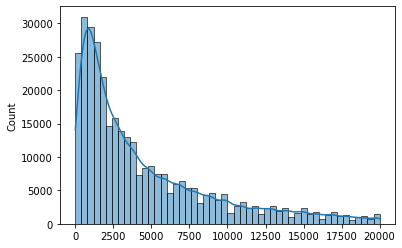

In [22]:
sns.histplot(data.Price.values, bins=50, kde=True);

Посмотрел как распределилась стоимость авто на графике

In [23]:
data = data.query('Price > 0')

Решил отсечь объявления, где стоимость указана 0.

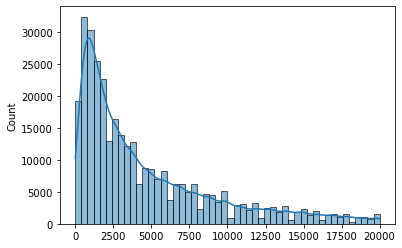

In [24]:
sns.histplot(data.Price.values, bins=50, kde=True);

Повторно посмотрел как распределилась стоимость авто на графике


In [25]:
data['Price'].value_counts()

500      5215
1500     5001
1200     4299
1000     4250
2500     4171
         ... 
7435        1
16845       1
17159       1
7396        1
10985       1
Name: Price, Length: 3669, dtype: int64

Теперь нет объявлений с нулевой стоимостью

In [26]:
data['Power'].describe()

count    326072.000000
mean        111.984697
std         182.968370
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [27]:
data = data[data['Power']<=1000]

Вижу что данные искажены, т.к. не может быть мощность 20000 л/с

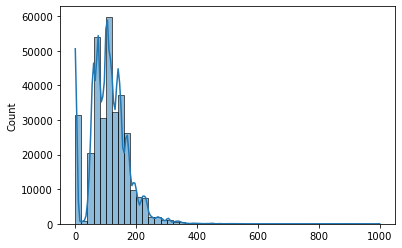

In [28]:
sns.histplot(data.Power.values, bins=50, kde=True);

Вижу большие выбросы в 0

In [29]:
data['Power'].describe()

count    325820.000000
mean        108.820781
std          62.650088
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

In [30]:
data = data[data['Power']>0]

Убрал значения меньше 0

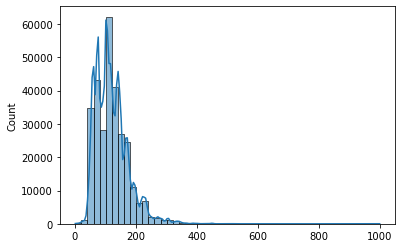

In [31]:
sns.histplot(data.Power.values, bins=50, kde=True);

Убрал значения меньше 0

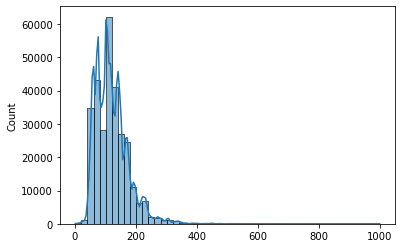

In [32]:
data = data[data['RegistrationYear']>1950]
data = data[data['RegistrationYear']<2023]
sns.histplot(data.Power.values, bins=50, kde=True);

Оставил автомобили с датой регистарции с 1950-2023 годы

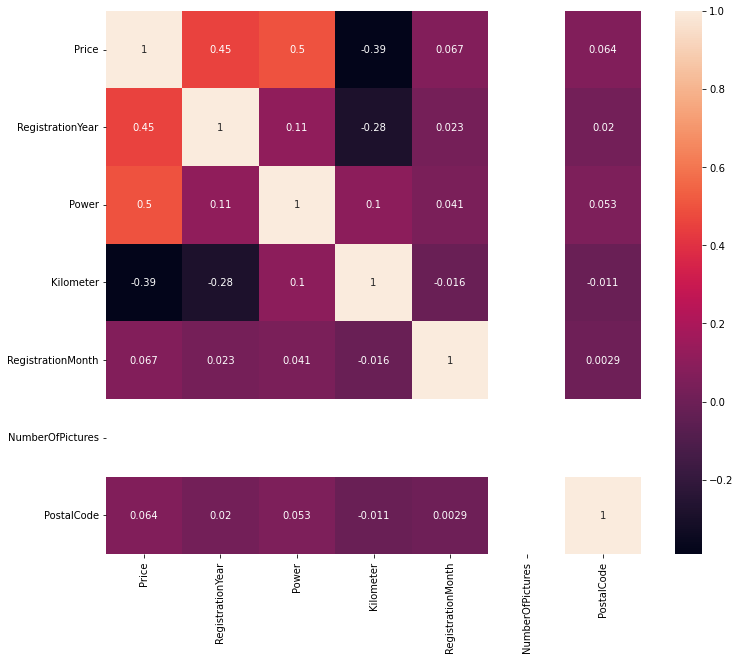

In [33]:
plt.figure(figsize=(12,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot = True);

Построил график корреляции параметров и принял решение удалить не нужные признаки

In [34]:
data=data.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)

Удалил DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures

In [35]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Просмотрел как выглядит финальный датасет

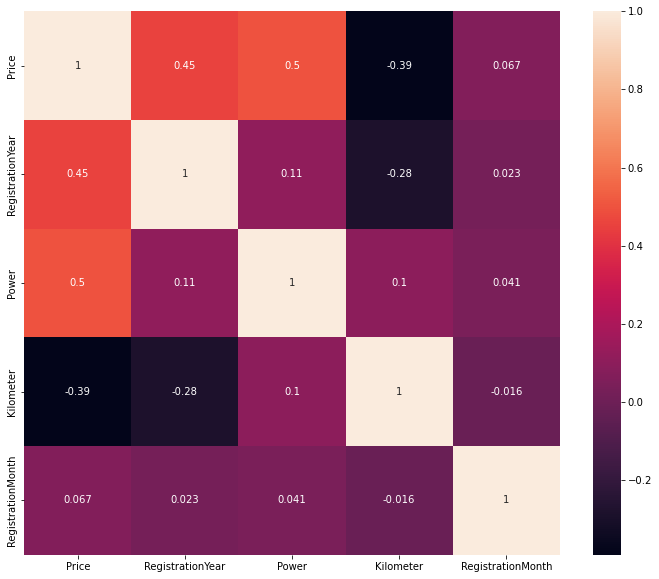

In [36]:
plt.figure(figsize=(12,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot = True);

Повторно построил график коррекляции параметров, на этом предобработку решил завершить

In [37]:
data = data[data['RegistrationMonth']>0]

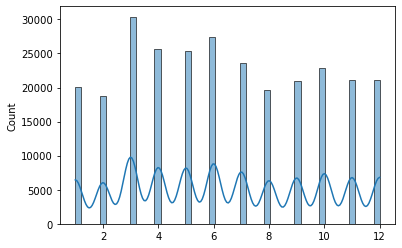

In [38]:
sns.histplot(data.RegistrationMonth.values, bins=50, kde=True);

### Вывод

В разделе №2 своего проекта я произвел предобработку данных:  
- Удалил полные дубликаты в датасете;  
- Преобразовал признаки с датой в формат **datetotime**;  
- Заменил в признаке Repairer значения **Nan** на **No** а потом заменил все **Yes** на **1** и **No** на **0**;  
- Удалил все записи со значениями **Nan** из признака **Model**;  
- Заменил на **0** все пропуски в **VehicleType**, **Gearbox**, **FuelType**;  
- Исключил из признака **Price** все записи со значением **0**;  
- В признаке **Power** скорректировал записи о мощности автомобилей в диапазоне от **0** до **1000** л/с;  
- Удалил все не важные признаки **DateCrawled**, **DateCreated**, **PostalCode**, **LastScreen**, **NumberOfPictures**;  
- Построил график корреляции параметров;  
- Предобрабола год регистрации авто **RegistrationYear** оставив только автомобили в диапазоне 1950-2023 гг.

## 3. Подготовка выборки для обучения

In [39]:
data_cat = pd.get_dummies(data, columns=['Brand','Model','VehicleType','Gearbox','FuelType', 'Repaired'])

С помощью **pd.get_dummies** перевел категории в числа

In [40]:
data_cat.head(3)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,...,FuelType_0,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_no,Repaired_yes
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,3600,2008,69,90000,7,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [41]:
features_cat = data_cat.drop(['Price'], axis=1) #выделил признаки
target_cat = data_cat['Price'] #выделил целевой признак
features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(features_cat, target_cat, test_size=0.3, random_state=RANDOMSTATE)

In [42]:
print('Train - 70%', features_train_cat.shape)
print('Test - 30%', features_test_cat.shape)

Train - 70% (193803, 314)
Test - 30% (83059, 314)


### Вывод

В разделе №3 своего проекта я подготовил данные для обучения, разделил датасет на обучающую и тестовую выборки, выделил целевые признаки.

## 4. Обучение моделей

### 4.1 LinearRegression

In [46]:
%%time

pipeline = Pipeline([('selector', SelectKBest()), ('model', LinearRegression())])
model_1 = GridSearchCV(estimator = pipeline, param_grid = {'selector__k':[3,4,5,6,7,8,9,10]}, n_jobs=-1, scoring="neg_root_mean_squared_error", cv=5, verbose=3)
model_1.fit(features_train_cat, target_train_cat)
model_1.best_estimator_.fit(features_train_cat, target_train_cat)

index_1 = np.argmax(model_1.cv_results_['mean_test_score'])
print('Значение RMSE для LinearRegression: {: 0.2f}'.format(-model_1.best_score_))
print('Время обучения модели: {: 0.2f}'.format(model_1.cv_results_['mean_fit_time'][index_1]))
print('Время предсказания модели: {: 0.2f}'.format(model_1.cv_results_['mean_score_time'][index_1]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Значение RMSE для LinearRegression:  2976.60
Время обучения модели:  18.65
Время предсказания модели:  0.10
CPU times: total: 8.66 s
Wall time: 3min 28s


Применил к модели LinearRegression GridSearchCV.

### 4.2 CatBoostRegressor

In [48]:
%%time

model_2 = CatBoostRegressor()
hyperparams = [{'random_state':[RANDOMSTATE]}]

model_2 = GridSearchCV(model_2, hyperparams, scoring='neg_root_mean_squared_error')
model_2.fit(features_train_cat, target_train_cat)
model_2.best_estimator_.fit(features_train_cat, target_train_cat)

index_2 = np.argmax(model_2.cv_results_['mean_test_score'])
print('Значение RMSE для CatBoostRegressor: {: 0.2f}'.format(-model_2.best_score_))
print('Время обучения модели: {: 0.2f}'.format(model_2.cv_results_['mean_fit_time'][index_2]))
print('Время предсказания модели: {: 0.2f}'.format(model_2.cv_results_['mean_score_time'][index_2]))

Learning rate set to 0.090839
0:	learn: 4370.5957659	total: 170ms	remaining: 2m 49s
1:	learn: 4128.9163247	total: 184ms	remaining: 1m 31s
2:	learn: 3904.9778298	total: 197ms	remaining: 1m 5s
3:	learn: 3709.4127081	total: 210ms	remaining: 52.2s
4:	learn: 3531.7209455	total: 225ms	remaining: 44.8s
5:	learn: 3372.0337358	total: 239ms	remaining: 39.5s
6:	learn: 3229.2286653	total: 252ms	remaining: 35.7s
7:	learn: 3104.1118342	total: 265ms	remaining: 32.8s
8:	learn: 2991.6044199	total: 279ms	remaining: 30.7s
9:	learn: 2895.3018247	total: 293ms	remaining: 29s
10:	learn: 2810.0830982	total: 305ms	remaining: 27.4s
Значение RMSE для CatBoostRegressor:  1595.76
Время обучения модели:  13.78
Время предсказания модели:  0.06
CPU times: total: 6min 57s
Wall time: 1min 40s


# 4.3 lightGBM

In [49]:
%%time

model_3 = LGBMRegressor()
hyperparams = [{'num_leaves':[5, 50, 100], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[RANDOMSTATE]}]

model_3 = GridSearchCV(model_3, hyperparams, scoring='neg_root_mean_squared_error')
model_3.fit(features_train_cat, target_train_cat)
model_3.best_estimator_.fit(features_train_cat, target_train_cat)

index_3 = np.argmax(model_3.cv_results_['mean_test_score'])
print('Значение RMSE для lightGBM: {: 0.2f}'.format(-model_3.best_score_))
print('Время обучения модели: {: 0.2f}'.format(model_3.cv_results_['mean_fit_time'][index_3]))
print('Время предсказания модели: {: 0.2f}'.format(model_3.cv_results_['mean_score_time'][index_3]))

Значение RMSE для lightGBM:  1571.14
Время обучения модели:  1.38
Время предсказания модели:  0.17
CPU times: total: 3min 52s
Wall time: 1min 3s


### 4.4 DecisionTreeRegressor

In [50]:
%%time

model_4 = DecisionTreeRegressor()
hyperparams = [{'max_depth': range(1, 5), 'random_state':[RANDOMSTATE]}]

model_4 = GridSearchCV(model_4, hyperparams, scoring='neg_root_mean_squared_error')
model_4.fit(features_train_cat, target_train_cat)
model_4.best_estimator_.fit(features_train_cat, target_train_cat)

index_4 = np.argmax(model_4.cv_results_['mean_test_score'])
print('Значение RMSE для LinearRegression: {: 0.2f}'.format(-model_4.best_score_))
print('Время обучения модели: {: 0.2f}'.format(model_4.cv_results_['mean_fit_time'][index_4]))
print('Время предсказания модели: {: 0.2f}'.format(model_4.cv_results_['mean_score_time'][index_4]))

Значение RMSE для LinearRegression:  2676.54
Время обучения модели:  1.43
Время предсказания модели:  0.05
CPU times: total: 24.7 s
Wall time: 24.6 s


### Вывод

В данном разделе своего проекта я обучил 4 различные модели:  
- LinearRegression;  
- CatBoostRegressor;  
- lightGBM;  
- DecisionTreeRegressor.

## 5. Анализ моделей

- Лучшее значение RMSE у модели lightGBM = 1571;  
- Лучшее время обучение у модели lightGBM = 1.41;  
- Самое низкое значение RMSE у модели LinearRegression = 2976;
- Дольше всех обучалась модель CatBoostRegressor = 17.12;
- Самое лучшее время предсказания модели у DecisionTreeRegressor = 0.06.  

In [51]:
df = pd.DataFrame({ 'Param':['Best_score', 'Время обучения', 'Время предсказания'],
                    'LR':[-model_1.best_score_, model_1.cv_results_['mean_fit_time'][index_1], model_1.cv_results_['mean_score_time'][index_1]],
                    'CatBoost':[-model_2.best_score_, model_2.cv_results_['mean_fit_time'][index_2], model_2.cv_results_['mean_score_time'][index_2]],
                    'lightGBM':[-model_3.best_score_, model_3.cv_results_['mean_fit_time'][index_3], model_3.cv_results_['mean_score_time'][index_3]],
                    'DecisionTreeReg':[-model_4.best_score_, model_4.cv_results_['mean_fit_time'][index_4], model_4.cv_results_['mean_score_time'][index_4]]
                })
                                      
df

,Param,LR,CatBoost,lightGBM,DecisionTreeReg
0,Best_score,2976.595696,1595.763572,1571.138034,2676.537005
1,Время обучения,18.649111,13.778009,1.377145,1.428537
2,Время предсказания,0.100049,0.058186,0.173195,0.053106


Обе модели градиентного бустинга (CatBoostRegressor, lightGBM) стабильно показали отличные показатели RMSE.

## 6. Проверка модели на тестовой выборке

In [52]:
%%time
rmse_5 = mean_squared_error(target_test_cat, model_3.predict(features_test_cat))
print('Значение RMSE для lightGBM: {: 0.2f}'.format(rmse_5 ** 0.5))

Значение RMSE для lightGBM:  1573.50
CPU times: total: 1.41 s
Wall time: 450 ms


### Вывод

В данном разделе своего проекта я выполнил тестирование модели lightGBM на тестовой выборке.  
- Значение RMSE незначительно увеличилось = 1573;  

### Вывод по проекту

В ходе работы было выполнено:

- Загружены данные и проведена предобработка;
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров;
- Выбрана лучшая модель по результатам метрики RMSE и времени обучения для тестирования на тестовой выборке.

В ходе выполнения проекта лучшей моделью стала модель **lightGBM**, у нее самое низкое значение RMSE и самое низкое время обучения.  

LinearRegression и RiDecisionTreeRegressor оказались очень медленными для решения данных задач.  